# Survival analysis using Kaplan Meier model for ecoli cohort

## Read journeys data

In [1]:
import os

from pathlib import Path

import pandas as pd


journeysDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'data', 'full_cohort', 'journry_times.csv'))
journeysDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm
0,2133327,567916,26/11/2018,NaN
1,2197822,572108,16/04/2019,17/07/2019
2,2138701,565491,12/11/2018,14/12/2021
3,330958,584875,02/03/2019,NaN
4,2189657,10719842,11/01/2019,NaN
...,...,...,...,...
6110,1855200,17748547,25/05/2023,NaN
6111,2240165,17881084,12/07/2023,29/07/2023
6112,2240165,17882738,12/07/2023,29/07/2023
6113,2514680,17883870,03/07/2023,NaN


## Read patient to tube mapping

In [2]:
import os

from pathlib import Path

import pandas as pd


mappingDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'patient_tube_id_mapping_full.tsv'), sep='\t')[['tube_code', 'PATIENT_ID']].drop_duplicates()
mappingDf

,tube_code,PATIENT_ID
0,AH19J072,213972.0
1,AH19J074,213972.0
2,AH19B003,526238.0
3,AH20A024,788941.0
4,AH20L041,1023735.0
...,...,...
3112,ALF22L076,639020.0
3113,ALF22L089,655404.0
3114,ALF22L138,2572048.0
3115,ALF23A102,2054964.0


## Merge mapping data with jouneys information

In [3]:
mergedDf = journeysDf.merge(
    mappingDf,
    how='inner',
    left_on='person_id',
    right_on='PATIENT_ID'
).drop(columns=['PATIENT_ID'])
mergedDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code
0,2133327,567916,26/11/2018,NaN,AH18K073
1,2133327,567916,26/11/2018,NaN,AH20C038
2,2197822,572108,16/04/2019,17/07/2019,AH19D031
3,2138701,565491,12/11/2018,14/12/2021,AH18K041
4,330958,584875,02/03/2019,NaN,AH19C004
...,...,...,...,...,...
5984,1855200,17748547,25/05/2023,NaN,ALF22D020
5985,2240165,17881084,12/07/2023,29/07/2023,AH19G055
5986,2240165,17882738,12/07/2023,29/07/2023,AH19G055
5987,2514680,17883870,03/07/2023,NaN,AH21G030


## Read lowscore tubeids

In [4]:
import os

from pathlib import Path

import pandas as pd


withoutSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_7_wos_tubeids.txt'))
withoutSignatureTubeidsDf

,tube_id
0,AH18J011
1,AH18J019
2,AH18J042
3,AH18J044
4,AH18K001
...,...
244,ALF23C090
245,ALF23C131
246,ALF23C136
247,ALF23C186


## Read highscore tubeids

In [5]:
import os

from pathlib import Path

import pandas as pd


withSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_7_ws_tubeids.txt'))
withSignatureTubeidsDf

,tube_id
0,AH18J016
1,AH18J032
2,AH18J033
3,AH18J035
4,AH18J061
...,...
607,ALF23C184
608,ALF23C185
609,ALF23C187
610,ALF23C213


## Without singature journeys

### Create data

In [6]:
withoutSignatureDf = mergedDf.merge(
    withoutSignatureTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
withoutSignatureDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id
0,2100650,603830,10/11/2018,NaN,AH18K026,AH18K026
1,2229540,605973,15/11/2018,16/09/2020,AH19B037,AH19B037
2,2229540,605973,15/11/2018,16/09/2020,AH19K080,AH19K080
3,2137240,620642,15/12/2018,NaN,AH18L042,AH18L042
4,2205347,10937623,07/01/2019,NaN,AH19A031,AH19A031
...,...,...,...,...,...,...
378,2016265,17507645,29/03/2023,NaN,ALF23C219,ALF23C219
379,2155922,17508983,16/03/2023,NaN,ALF23C136,ALF23C136
380,2016265,17546937,29/03/2023,NaN,ALF23C219,ALF23C219
381,2514680,17684050,03/07/2023,NaN,AH21G030,AH21G030


### Format data

In [7]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
T, E = datetimes_to_durations(withoutSignatureDf.admittime_adm, withoutSignatureDf.deathtime_adm, freq='D', dayfirst=True)

### Kaplan Meier Plot

In [8]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 383 total observations, 277 right-censored observations>

<Axes: xlabel='timeline'>

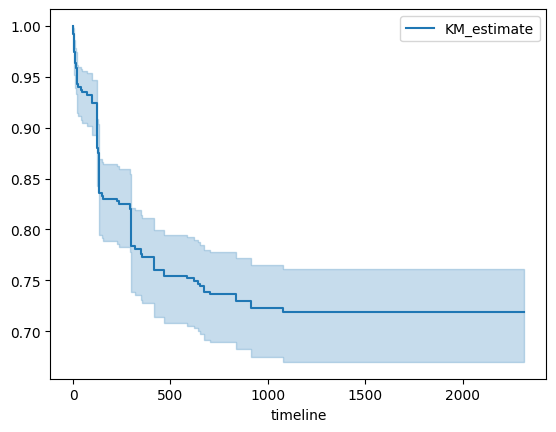

In [9]:
kmf.plot_survival_function()

## With signature journeys

### Create data

In [10]:
withSignatureDf = mergedDf.merge(
    withSignatureTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
withSignatureDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id
0,2197822,572108,16/04/2019,17/07/2019,AH19D031,AH19D031
1,2189657,10719842,11/01/2019,NaN,AH21I035,AH21I035
2,2221159,11137049,23/11/2018,NaN,AH18K068,AH18K068
3,2134287,601914,23/10/2018,15/03/2020,AH20A020,AH20A020
4,2177229,603897,25/01/2019,01/02/2019,AH19A078,AH19A078
...,...,...,...,...,...,...
979,2240165,17544825,12/07/2023,29/07/2023,AH19G055,AH19G055
980,2402765,17578530,26/04/2023,NaN,AH21B065,AH21B065
981,2402765,17597095,26/04/2023,NaN,AH21B065,AH21B065
982,2240165,17881084,12/07/2023,29/07/2023,AH19G055,AH19G055


### Format data

In [11]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
T, E = datetimes_to_durations(withSignatureDf.admittime_adm, withSignatureDf.deathtime_adm, freq='D')

/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/lifelines/utils/__init__.py:684: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  start_times_ = pd.to_datetime(start_times, dayfirst=dayfirst, format=format)
/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/lifelines/utils/__init__.py:685: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end_times_ = pd.to_datetime(end_times, dayfirst=dayfirst, errors="coerce", format=format)


### Kaplan Meier Plot

In [12]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 984 total observations, 637 right-censored observations>

<Axes: xlabel='timeline'>

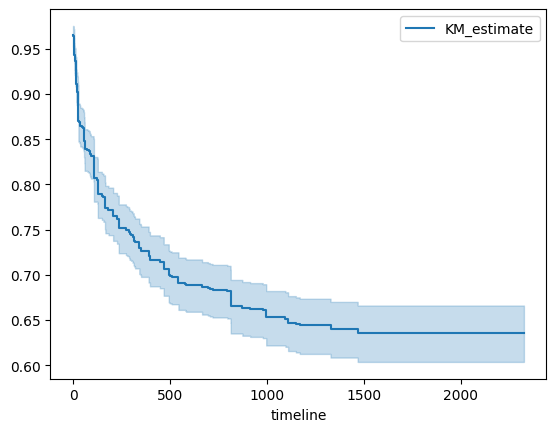

In [13]:
kmf.plot_survival_function()

## Overlapping survival analysis for low score and high score patients

### Create data

In [14]:
withoutSignatureDf = mergedDf.merge(
    withoutSignatureTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
withoutSignatureDf['cohort'] = 'Without Signature'
withoutSignatureDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort
0,2100650,603830,10/11/2018,NaN,AH18K026,AH18K026,Without Signature
1,2229540,605973,15/11/2018,16/09/2020,AH19B037,AH19B037,Without Signature
2,2229540,605973,15/11/2018,16/09/2020,AH19K080,AH19K080,Without Signature
3,2137240,620642,15/12/2018,NaN,AH18L042,AH18L042,Without Signature
4,2205347,10937623,07/01/2019,NaN,AH19A031,AH19A031,Without Signature
...,...,...,...,...,...,...,...
378,2016265,17507645,29/03/2023,NaN,ALF23C219,ALF23C219,Without Signature
379,2155922,17508983,16/03/2023,NaN,ALF23C136,ALF23C136,Without Signature
380,2016265,17546937,29/03/2023,NaN,ALF23C219,ALF23C219,Without Signature
381,2514680,17684050,03/07/2023,NaN,AH21G030,AH21G030,Without Signature


In [15]:
withSignatureDf = mergedDf.merge(
    withSignatureTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
withSignatureDf['cohort'] = 'With Signature'
withSignatureDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort
0,2197822,572108,16/04/2019,17/07/2019,AH19D031,AH19D031,With Signature
1,2189657,10719842,11/01/2019,NaN,AH21I035,AH21I035,With Signature
2,2221159,11137049,23/11/2018,NaN,AH18K068,AH18K068,With Signature
3,2134287,601914,23/10/2018,15/03/2020,AH20A020,AH20A020,With Signature
4,2177229,603897,25/01/2019,01/02/2019,AH19A078,AH19A078,With Signature
...,...,...,...,...,...,...,...
979,2240165,17544825,12/07/2023,29/07/2023,AH19G055,AH19G055,With Signature
980,2402765,17578530,26/04/2023,NaN,AH21B065,AH21B065,With Signature
981,2402765,17597095,26/04/2023,NaN,AH21B065,AH21B065,With Signature
982,2240165,17881084,12/07/2023,29/07/2023,AH19G055,AH19G055,With Signature


In [16]:
import pandas as pd


conbinedDf = pd.concat([withoutSignatureDf, withSignatureDf], ignore_index=True)
conbinedDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort
0,2100650,603830,10/11/2018,NaN,AH18K026,AH18K026,Without Signature
1,2229540,605973,15/11/2018,16/09/2020,AH19B037,AH19B037,Without Signature
2,2229540,605973,15/11/2018,16/09/2020,AH19K080,AH19K080,Without Signature
3,2137240,620642,15/12/2018,NaN,AH18L042,AH18L042,Without Signature
4,2205347,10937623,07/01/2019,NaN,AH19A031,AH19A031,Without Signature
...,...,...,...,...,...,...,...
1362,2240165,17544825,12/07/2023,29/07/2023,AH19G055,AH19G055,With Signature
1363,2402765,17578530,26/04/2023,NaN,AH21B065,AH21B065,With Signature
1364,2402765,17597095,26/04/2023,NaN,AH21B065,AH21B065,With Signature
1365,2240165,17881084,12/07/2023,29/07/2023,AH19G055,AH19G055,With Signature


### Format data

In [17]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
T, E = datetimes_to_durations(conbinedDf.admittime_adm, conbinedDf.deathtime_adm, freq='D', dayfirst=True)

conbinedDf['T'] = T
conbinedDf['E'] = E
conbinedDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort,T,E
0,2100650,603830,10/11/2018,NaN,AH18K026,AH18K026,Without Signature,2308.0,False
1,2229540,605973,15/11/2018,16/09/2020,AH19B037,AH19B037,Without Signature,671.0,True
2,2229540,605973,15/11/2018,16/09/2020,AH19K080,AH19K080,Without Signature,671.0,True
3,2137240,620642,15/12/2018,NaN,AH18L042,AH18L042,Without Signature,2273.0,False
4,2205347,10937623,07/01/2019,NaN,AH19A031,AH19A031,Without Signature,2250.0,False
...,...,...,...,...,...,...,...,...,...
1362,2240165,17544825,12/07/2023,29/07/2023,AH19G055,AH19G055,With Signature,17.0,True
1363,2402765,17578530,26/04/2023,NaN,AH21B065,AH21B065,With Signature,680.0,False
1364,2402765,17597095,26/04/2023,NaN,AH21B065,AH21B065,With Signature,680.0,False
1365,2240165,17881084,12/07/2023,29/07/2023,AH19G055,AH19G055,With Signature,17.0,True


### Kaplan Meier Plot (complete timeline)

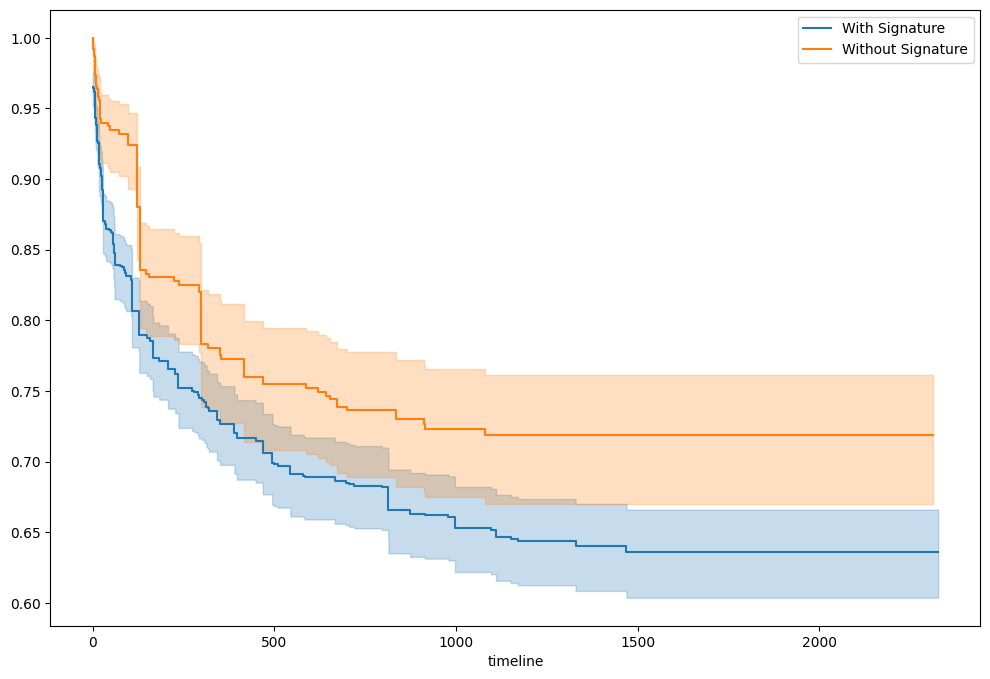

In [18]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(12, 8))

kmf = KaplanMeierFitter()

for name, grouped_df in conbinedDf.groupby('cohort'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)

### Kaplan Meier Plot (zero to 1200 days)

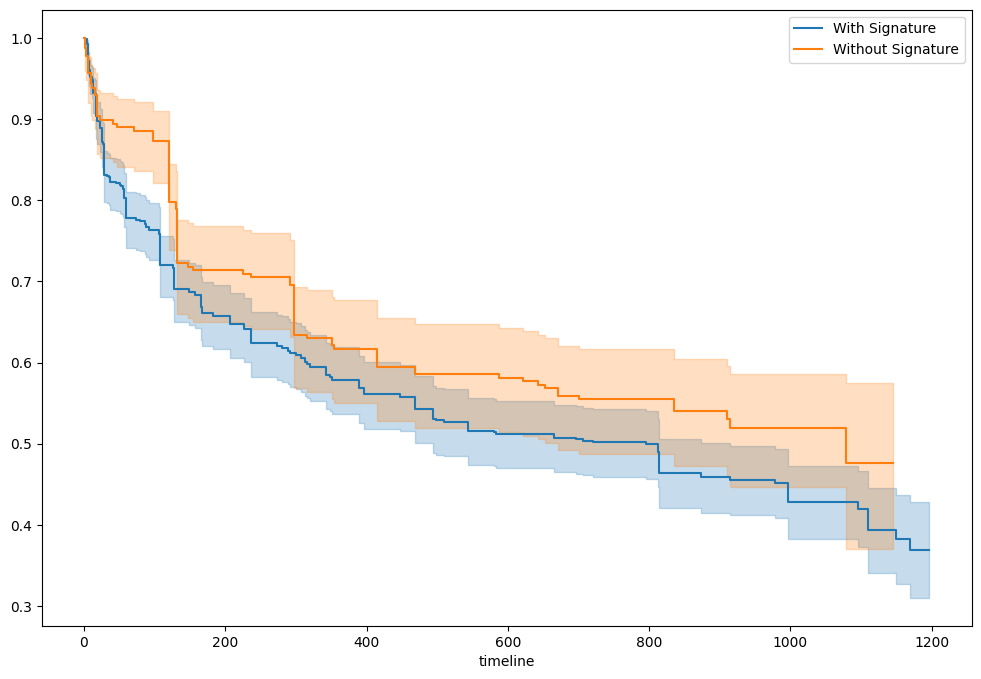

In [19]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(12, 8))

kmf = KaplanMeierFitter()

for name, grouped_df in conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < 1200)].groupby('cohort'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)

## Log Rank Test

In [20]:
# pip install Jinja2

### Complete timeline

In [21]:
from lifelines.statistics import logrank_test


results = logrank_test(
    conbinedDf[(conbinedDf.cohort == 'With Signature')]['T'],
    conbinedDf[(conbinedDf.cohort == 'Without Signature')]['T'],
    event_observed_A=conbinedDf[(conbinedDf.cohort == 'With Signature')]['E'],
    event_observed_B=conbinedDf[(conbinedDf.cohort == 'Without Signature')]['E'],
    )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.49 0.01      7.34

### Zero to 1200 days

In [22]:
from lifelines.statistics import logrank_test

filteredDf = conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < 1200)]

results = logrank_test(
    filteredDf[(filteredDf.cohort == 'With Signature')]['T'],
    filteredDf[(filteredDf.cohort == 'Without Signature')]['T'],
    event_observed_A=filteredDf[(filteredDf.cohort == 'With Signature')]['E'],
    event_observed_B=filteredDf[(filteredDf.cohort == 'Without Signature')]['E'],
    )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.84 0.05      4.32